In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Caricamento del Dataset
FILE_PATH = '../data/trajectories.csv'

# Leggiamo senza header perché il file contiene solo numeri
df = pd.read_csv(FILE_PATH, header=None, index_col=False)

print(f"Dimensione totale dataset: {df.shape}")

Dimensione totale dataset: (400400, 56)


In [34]:
def split_trajectories(df):
    """
    Spezza il dataframe in una lista di array numpy, uno per ogni traiettoria.
    Assume che la colonna 0 sia il tempo.
    """
    trajectories = []

    # Identifichiamo dove il tempo ricomincia da capo (o è 0)
    # Se il tempo al passo t è minore del tempo al passo t-1, è una nuova traiettoria
    time_col = df.iloc[:, 0].values
    # Troviamo gli indici dove inizia una nuova traiettoria
    split_indices = np.where(np.diff(time_col) < 0)[0] + 1

    # Splittiamo il dataframe in questi punti
    traj_list = np.split(df.values, split_indices)

    # Rimuoviamo la colonna del tempo (col 0) dalle feature per il training
    # Teniamo solo le 55 colonne fisiche
    clean_trajectories = [t[:, 1:] for t in traj_list]

    return clean_trajectories

# Eseguiamo lo split
all_trajectories = split_trajectories(df)
print(f"Trovate {len(all_trajectories)} traiettorie distinte.")
print(f"Shape di una traiettoria: {all_trajectories[0].shape}")

Trovate 400 traiettorie distinte.
Shape di una traiettoria: (1001, 55)


In [35]:
# Dividiamo le traiettorie in Train (80%) e Test (20%)
train_traj, test_traj = train_test_split(all_trajectories, test_size=0.2, random_state=42)

# Normalizzazione (MinMax tra 0 e 1 o -1 e 1 è standard per dati quantistici)
# Fittiamo lo scaler SOLO sul training set per correttezza metodologica
scaler = MinMaxScaler(feature_range=(-1, 1))

# Concateniamo temporaneamente per fittare lo scaler
train_concat = np.vstack(train_traj)
scaler.fit(train_concat)

# Applichiamo la trasformazione a ogni singola traiettoria
train_traj_norm = [scaler.transform(t) for t in train_traj]
test_traj_norm = [scaler.transform(t) for t in test_traj]

In [36]:
def create_dataset(trajectories, input_width, forecast_horizon=1):
    """
    Crea finestre scorrevoli (X, y).
    input_width: quanti step guardo indietro (es. 10)
    forecast_horizon: quanti step prevedo in avanti (es. 1)
    """
    X, y = [], []

    for t in trajectories:
        # t è una matrice (TimeSteps, 55 Features)
        for i in range(len(t) - input_width - forecast_horizon + 1):
            # Input: da i a i+width
            X.append(t[i : i + input_width])
            # Target: lo step subito dopo (o sequenza, dipenda da come vuoi l'output)
            # Qui prendiamo il singolo step successivo per predizione puntuale
            y.append(t[i + input_width : i + input_width + forecast_horizon])

    return np.array(X), np.array(y)

# --- CREAZIONE DATASET REALE ---
# Qui definisci le tue "2 Time Windows" da testare per l'esame
WINDOW_SIZE_1 = 10  # Configurazione A
WINDOW_SIZE_2 = 20  # Configurazione B (da usare dopo)

# Creiamo i dati per la Configurazione A
X_train, y_train = create_dataset(train_traj_norm, input_width=WINDOW_SIZE_1)
X_test, y_test = create_dataset(test_traj_norm, input_width=WINDOW_SIZE_1)

# Rimuoviamo la dimensione inutile dal target se forecast_horizon=1
# Da (N, 1, 55) a (N, 55)
y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)

print(f"Training Data Shape: {X_train.shape}") # (N_samples, 10, 55)
print(f"Training Target Shape: {y_train.shape}") # (N_samples, 55)

Training Data Shape: (317120, 10, 55)
Training Target Shape: (317120, 55)


In [37]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [38]:
class QuantumRNN(Model):
    def __init__(self, hidden_units, output_dim, dropout_rate=0.2):
        super(QuantumRNN, self).__init__()

        # Layer di Normalizzazione
        self.norm = layers.LayerNormalization()

        # GRU 1: return_sequences=True per passare la sequenza alla seconda GRU
        # Aggiungiamo dropout e recurrent_dropout per regolarizzazione
        self.gru1 = layers.GRU(
            hidden_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # GRU 2: Elabora la sequenza e restituisce solo l'ultimo stato
        self.gru2 = layers.GRU(
            hidden_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # Dense Layer finale per la regressione (56 parametri)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # Il parametro 'training' gestisce automaticamente il dropout:
        # viene attivato solo durante fit/train e disattivato durante l'esame (inferenza)
        x = self.norm(inputs)
        x = self.gru1(x, training=training)
        x = self.gru2(x, training=training)
        return self.dense_out(x)

In [39]:
model = QuantumRNN(hidden_units=64, output_dim=55, dropout_rate=0.2)

In [40]:
import time
from tqdm import tqdm # Per la barra di caricamento

# --- 1. DEFINIZIONE IPERPARAMETRI E OTTIMIZZATORE ---
EPOCHS = 30  # Totale epoche (10 clean + 10 masked + 10 noise)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

# Metriche per monitorare l'andamento
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
train_mae_metric = tf.keras.metrics.MeanAbsoluteError(name='train_mae')

# --- 2. FUNZIONI DI DATA AUGMENTATION (STRATEGIE) ---

def apply_masking(x, prob=0.15):
    """
    Masked Modeling: Imposta a zero il 15% dei valori di input casualmente.
    Serve a rendere il modello robusto a dati mancanti.
    """
    mask = tf.random.uniform(shape=tf.shape(x)) > prob
    # Cast della maschera a float (0.0 o 1.0)
    mask = tf.cast(mask, dtype=x.dtype)
    return x * mask

def apply_noise(x, stddev=0.05):
    """
    Noise Injection: Aggiunge rumore gaussiano.
    Simula l'incertezza dello 'Scheduled Sampling' in regressione.
    """
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
    return x + noise

# --- 3. IL PASSO DI TRAINING (SINGLE STEP) ---
# Usiamo @tf.function per compilare il grafo e renderlo velocissimo
@tf.function
def train_step(model, x_batch, y_batch, strategy_phase):

    # Applicazione della strategia in base alla fase
    if strategy_phase == "masking":
        x_input = apply_masking(x_batch)
    elif strategy_phase == "noise":
        x_input = apply_noise(x_batch)
    else:
        x_input = x_batch # Standard (Clean)

    with tf.GradientTape() as tape:
        # 1. Forward Pass
        # training=True attiva il Dropout definito nella classe RNN
        predictions = model(x_input, training=True)

        # 2. Calcolo della Loss
        loss = loss_fn(y_batch, predictions)

    # 3. Calcolo dei Gradienti
    gradients = tape.gradient(loss, model.trainable_variables)

    # 4. Aggiornamento dei Pesi (Backpropagation)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # 5. Aggiornamento Metriche
    train_loss_metric.update_state(loss)
    train_mae_metric.update_state(y_batch, predictions)

    return loss

@tf.function
def test_step(model, x_batch, y_batch):
    # training=False disattiva il Dropout per l'inferenza
    predictions = model(x_batch, training=False)
    t_loss = loss_fn(y_batch, predictions)
    test_loss_metric.update_state(t_loss)

# --- 4. IL CICLO PRINCIPALE DI ADDESTRAMENTO ---

print(f"Inizio training su {len(train_dataset)} batch...")
history = {'loss': [], 'val_loss': [], 'mae': []}

# Inizializza il modello (se non lo hai già fatto)
# model = QuantumRNN(hidden_units=64, output_dim=55, dropout_rate=0.2)

for epoch in range(EPOCHS):
    start_time = time.time()

    # Reset delle metriche all'inizio di ogni epoca
    train_loss_metric.reset_state()
    test_loss_metric.reset_state()
    train_mae_metric.reset_state()

    # --- DETERMINA LA STRATEGIA ---
    if epoch < 10:
        phase = "standard"
        desc = "Standard Training"
    elif epoch < 20:
        phase = "masking"
        desc = "Masked Modeling (15%)"
    else:
        phase = "noise"
        desc = "Noise Injection"

    # --- TRAINING LOOP (Batch by Batch) ---
    # tqdm crea la barra di caricamento
    with tqdm(total=len(train_dataset), desc=f"Epoch {epoch+1}/{EPOCHS} [{desc}]", unit="batch") as pbar:
        for x_batch, y_batch in train_dataset:
            loss_val = train_step(model, x_batch, y_batch, phase)

            # Aggiorna la barra con la loss attuale
            pbar.set_postfix({'loss': f'{loss_val:.4f}'})
            pbar.update(1)

    # --- VALIDATION LOOP ---
    for x_test, y_test in test_dataset:
        test_step(model, x_test, y_test)

    # --- SALVATAGGIO STORICO E STAMPA ---
    history['loss'].append(train_loss_metric.result().numpy())
    history['val_loss'].append(test_loss_metric.result().numpy())
    history['mae'].append(train_mae_metric.result().numpy())

    print(f"Epoch {epoch+1} Summary:")
    print(f" - Train Loss: {train_loss_metric.result():.4f}")
    print(f" - Train MAE:  {train_mae_metric.result():.4f}")
    print(f" - Test Loss:  {test_loss_metric.result():.4f}")
    print(f" - Time: {time.time() - start_time:.1f}s")
    print("-" * 50)

# --- 5. SALVATAGGIO FINALE ---
# Salviamo i pesi per l'esame
model.save_weights('../models/rnn_final_weights.h5')
print("Training completato e modello salvato!")

Inizio training su 4955 batch...


Epoch 1/30 [Standard Training]: 100%|██████████| 4955/4955 [00:50<00:00, 98.94batch/s, loss=0.0105] 


Epoch 1 Summary:
 - Train Loss: 0.0185
 - Train MAE:  0.1026
 - Test Loss:  0.0130
 - Time: 55.3s
--------------------------------------------------


Epoch 2/30 [Standard Training]:  73%|███████▎  | 3598/4955 [00:27<00:12, 109.63batch/s, loss=0.0123]

Epoch 2 Summary:
 - Train Loss: 0.0125
 - Train MAE:  0.0849
 - Test Loss:  0.0109
 - Time: 41.5s
--------------------------------------------------


Epoch 3/30 [Standard Training]: 100%|██████████| 4955/4955 [00:38<00:00, 129.34batch/s, loss=0.0101]


Epoch 3 Summary:
 - Train Loss: 0.0120
 - Train MAE:  0.0831
 - Test Loss:  0.0101
 - Time: 42.4s
--------------------------------------------------


Epoch 4/30 [Standard Training]:  92%|█████████▏| 4541/4955 [00:34<00:03, 124.48batch/s, loss=0.0133]

Epoch 4 Summary:
 - Train Loss: 0.0118
 - Train MAE:  0.0824
 - Test Loss:  0.0098
 - Time: 42.1s
--------------------------------------------------


Epoch 5/30 [Standard Training]: 100%|██████████| 4955/4955 [00:37<00:00, 131.33batch/s, loss=0.0100]


Epoch 5 Summary:
 - Train Loss: 0.0117
 - Train MAE:  0.0820
 - Test Loss:  0.0095
 - Time: 41.9s
--------------------------------------------------


Epoch 7/30 [Standard Training]: 100%|██████████| 4955/4955 [00:38<00:00, 128.64batch/s, loss=0.0095]


Epoch 7 Summary:
 - Train Loss: 0.0116
 - Train MAE:  0.0815
 - Test Loss:  0.0094
 - Time: 42.3s
--------------------------------------------------


Epoch 8/30 [Standard Training]:  93%|█████████▎| 4596/4955 [00:33<00:02, 136.61batch/s, loss=0.0110]

Epoch 8 Summary:
 - Train Loss: 0.0116
 - Train MAE:  0.0814
 - Test Loss:  0.0094
 - Time: 40.5s
--------------------------------------------------


Epoch 9/30 [Standard Training]: 100%|██████████| 4955/4955 [00:38<00:00, 128.81batch/s, loss=0.0100]


Epoch 9 Summary:
 - Train Loss: 0.0115
 - Train MAE:  0.0811
 - Test Loss:  0.0093
 - Time: 42.6s
--------------------------------------------------


Epoch 10/30 [Standard Training]: 100%|██████████| 4955/4955 [00:37<00:00, 133.31batch/s, loss=0.0099]


Epoch 10 Summary:
 - Train Loss: 0.0114
 - Train MAE:  0.0809
 - Test Loss:  0.0093
 - Time: 41.1s
--------------------------------------------------


Epoch 11/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:46<00:00, 106.76batch/s, loss=0.0110]


Epoch 11 Summary:
 - Train Loss: 0.0144
 - Train MAE:  0.0916
 - Test Loss:  0.0107
 - Time: 50.4s
--------------------------------------------------


Epoch 12/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:38<00:00, 129.58batch/s, loss=0.0114]


Epoch 12 Summary:
 - Train Loss: 0.0132
 - Train MAE:  0.0877
 - Test Loss:  0.0103
 - Time: 42.2s
--------------------------------------------------


Epoch 13/30 [Masked Modeling (15%)]:  91%|█████████ | 4511/4955 [00:34<00:03, 129.80batch/s, loss=0.0130]

Epoch 13 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0105
 - Time: 52.7s
--------------------------------------------------


Epoch 14/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:38<00:00, 127.89batch/s, loss=0.0113]


Epoch 14 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0104
 - Time: 42.8s
--------------------------------------------------


Epoch 15/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:38<00:00, 127.56batch/s, loss=0.0113]


Epoch 15 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0103
 - Time: 50.7s
--------------------------------------------------


Epoch 16/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:39<00:00, 125.09batch/s, loss=0.0110]


Epoch 16 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0101
 - Time: 43.5s
--------------------------------------------------


Epoch 17/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:39<00:00, 126.10batch/s, loss=0.0112]


Epoch 17 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0101
 - Time: 43.3s
--------------------------------------------------


Epoch 18/30 [Masked Modeling (15%)]: 100%|██████████| 4955/4955 [00:39<00:00, 126.40batch/s, loss=0.0114]


Epoch 18 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0876
 - Test Loss:  0.0100
 - Time: 43.1s
--------------------------------------------------


Epoch 19/30 [Masked Modeling (15%)]:  71%|███████▏  | 3542/4955 [00:27<00:10, 134.16batch/s, loss=0.0138]

Epoch 19 Summary:
 - Train Loss: 0.0131
 - Train MAE:  0.0875
 - Test Loss:  0.0097
 - Time: 42.9s
--------------------------------------------------


Epoch 21/30 [Noise Injection]:  92%|█████████▏| 4575/4955 [00:37<00:02, 134.17batch/s, loss=0.0135].0128]

Epoch 21 Summary:
 - Train Loss: 0.0121
 - Train MAE:  0.0840
 - Test Loss:  0.0092
 - Time: 44.5s
--------------------------------------------------


Epoch 22/30 [Noise Injection]:  56%|█████▌    | 2775/4955 [00:21<00:16, 135.87batch/s, loss=0.0123]

Epoch 22 Summary:
 - Train Loss: 0.0120
 - Train MAE:  0.0834
 - Test Loss:  0.0089
 - Time: 41.5s
--------------------------------------------------


Epoch 23/30 [Noise Injection]: 100%|██████████| 4955/4955 [00:39<00:00, 125.85batch/s, loss=0.0100]


Epoch 23 Summary:
 - Train Loss: 0.0119
 - Train MAE:  0.0830
 - Test Loss:  0.0089
 - Time: 43.3s
--------------------------------------------------


Epoch 24/30 [Noise Injection]:  90%|████████▉ | 4443/4955 [00:34<00:04, 127.16batch/s, loss=0.0107]

Epoch 24 Summary:
 - Train Loss: 0.0118
 - Train MAE:  0.0825
 - Test Loss:  0.0088
 - Time: 43.0s
--------------------------------------------------


Epoch 25/30 [Noise Injection]: 100%|██████████| 4955/4955 [00:39<00:00, 126.39batch/s, loss=0.0102]


Epoch 25 Summary:
 - Train Loss: 0.0117
 - Train MAE:  0.0821
 - Test Loss:  0.0086
 - Time: 43.1s
--------------------------------------------------


Epoch 27/30 [Noise Injection]: 100%|██████████| 4955/4955 [00:38<00:00, 128.33batch/s, loss=0.0098]


Epoch 27 Summary:
 - Train Loss: 0.0115
 - Train MAE:  0.0816
 - Test Loss:  0.0085
 - Time: 42.4s
--------------------------------------------------


Epoch 28/30 [Noise Injection]:  55%|█████▍    | 2707/4955 [00:21<00:18, 119.54batch/s, loss=0.0111]

Epoch 28 Summary:
 - Train Loss: 0.0115
 - Train MAE:  0.0814
 - Test Loss:  0.0084
 - Time: 42.9s
--------------------------------------------------


Epoch 29/30 [Noise Injection]: 100%|██████████| 4955/4955 [00:40<00:00, 122.57batch/s, loss=0.0102]


Epoch 29 Summary:
 - Train Loss: 0.0114
 - Train MAE:  0.0812
 - Test Loss:  0.0083
 - Time: 44.4s
--------------------------------------------------


Epoch 30/30 [Noise Injection]: 100%|█████████▉| 4941/4955 [00:39<00:00, 124.22batch/s, loss=0.0119]

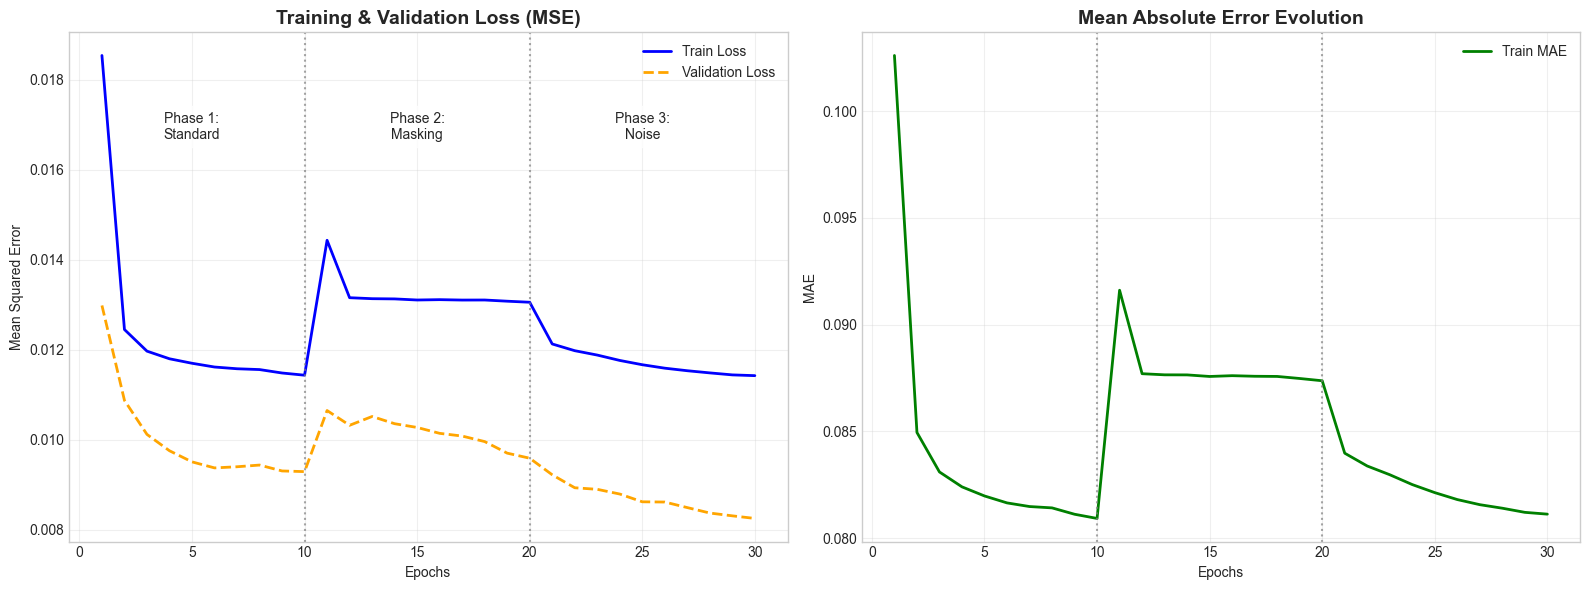

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Impostiamo uno stile professionale per i grafici
plt.style.use('seaborn-v0_8-whitegrid')

def plot_training_phases(history, filename="training_loss.png"):
    """
    Plotta la Loss e il MAE evidenziando le 3 fasi del curriculum learning.
    """
    epochs = range(1, len(history['loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- PLOT 1: LOSS (MSE) ---
    ax1.plot(epochs, history['loss'], label='Train Loss', color='blue', linewidth=2)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)

    # Linee verticali per le fasi
    ax1.axvline(x=10, color='gray', linestyle=':', alpha=0.7)
    ax1.axvline(x=20, color='gray', linestyle=':', alpha=0.7)

    # Annotazioni delle fasi
    y_pos = max(history['loss']) * 0.9
    ax1.text(5, y_pos, 'Phase 1:\nStandard', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    ax1.text(15, y_pos, 'Phase 2:\nMasking', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    ax1.text(25, y_pos, 'Phase 3:\nNoise', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    ax1.set_title('Training & Validation Loss (MSE)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- PLOT 2: MAE ---
    ax2.plot(epochs, history['mae'], label='Train MAE', color='green', linewidth=2)

    # Linee verticali
    ax2.axvline(x=10, color='gray', linestyle=':', alpha=0.7)
    ax2.axvline(x=20, color='gray', linestyle=':', alpha=0.7)

    ax2.set_title('Mean Absolute Error Evolution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    # Salvataggio ad alta risoluzione per il report
    plt.savefig(filename, dpi=300)
    plt.show()

# --- ESECUZIONE ---
# Assumendo che 'history' sia il dizionario popolato nel loop precedente
# e che X_test, y_test siano già definiti:

# 1. Genera grafici della Loss
plot_training_phases(history)

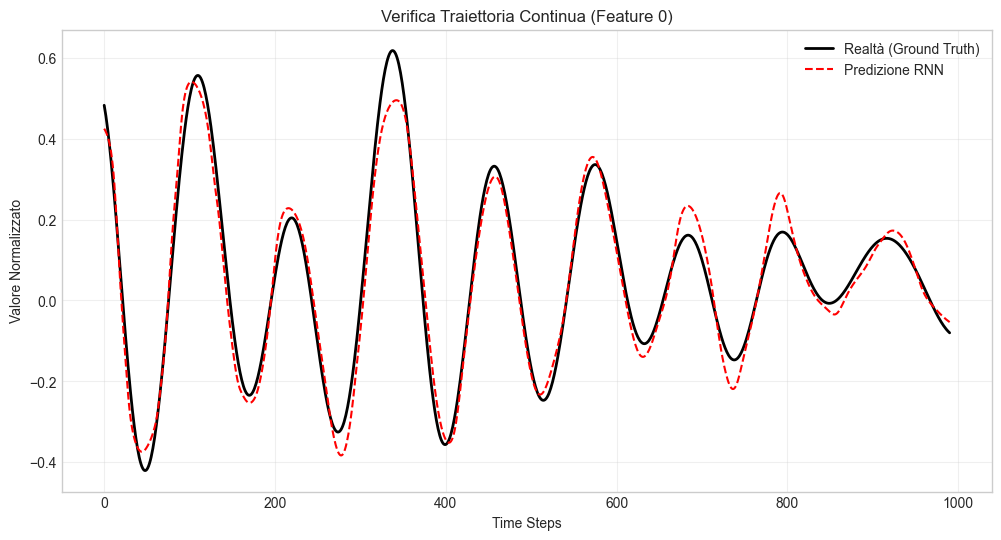

In [46]:
def plot_trajectory_check(model, trajectories_list, scaler, window_size=10, filename="predictions_check.png"):
    """
    Prende UNA traiettoria intera dal test set originale, crea le finestre
    e fa la predizione passo-passo per vedere se segue la realtà.
    """
    # 1. Prendiamo una traiettoria di test a caso (es. la numero 0)
    # trajectories_list deve essere la lista di array numpy PRIMA del windowing
    traj_idx = 1
    real_traj = trajectories_list[traj_idx] # Shape (Lunghezza, 55)

    # Normalizziamo (se non è già normalizzata)
    # Nota: Assumiamo che 'real_traj' sia già scalata se passiamo test_traj_norm

    # 2. Prepariamo l'input per il modello
    # Dobbiamo creare le finestre sequenziali per questa specifica traiettoria
    X_seq, y_seq = [], []
    for i in range(len(real_traj) - window_size):
        X_seq.append(real_traj[i : i + window_size])
        y_seq.append(real_traj[i + window_size]) # Il target è lo step successivo

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # 3. Predizione
    # training=False disattiva dropout
    y_pred = model.predict(X_seq, batch_size=32, verbose=0)

    # 4. Plotting
    plt.figure(figsize=(12, 6))

    # Plottiamo solo la feature 0 (Magnetizzazione Z) per chiarezza
    feature_idx = 0

    plt.plot(y_seq[:, feature_idx], label='Realtà (Ground Truth)', color='black', linewidth=2)
    plt.plot(y_pred[:, feature_idx], label='Predizione RNN', color='red', linestyle='--')

    plt.title(f'Verifica Traiettoria Continua (Feature {feature_idx})')
    plt.xlabel('Time Steps')
    plt.ylabel('Valore Normalizzato')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(filename, dpi=300)
    plt.show()

# ESECUZIONE (Usa le variabili che avevi nel caricamento dati)
# test_traj_norm è la lista delle traiettorie di test normalizzate
plot_trajectory_check(model, test_traj_norm, scaler, window_size=10)

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
